In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# Загрузка данных
labels = np.load('data/labels.npy')
images = np.load('data/images.npy')

In [5]:
# Применение фильтров к изображению
def preprocess_image(image):
    # Преобразование в оттенки серого
    gray = cv2.cvtColor(image, cv2.COlayersOR_RGB2GRAY)
    
    # Усиление контрастности с помощью ClayersAHE
    clahe = cv2.createClayersAHE(cliplayersimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Нормализация и добавление оси канала
    normalized = enhanced / 255.0
    processed_image = np.expand_dims(normalized, axis=-1)

    # Повторное преобразование в формат RGB
    processed_image = np.repeat(processed_image, 3, axis=-1)
    
    return processed_image

In [6]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Нормализация изображений
X_train = X_train / 255.0
X_test = X_test / 255.0

# Кодирование меток в формат one-hot
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)


In [16]:
# Создание модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(label_binarizer.classes_), activation='softmax')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Использование callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

In [17]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.0441 - loss: 4.2883 - val_accuracy: 0.0298 - val_loss: 3.5842 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.0500 - loss: 3.5171 - val_accuracy: 0.0653 - val_loss: 3.2820 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.0873 - loss: 3.2054 - val_accuracy: 0.1670 - val_loss: 2.8053 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.2032 - loss: 2.6410 - val_accuracy: 0.4065 - val_loss: 1.9340 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.3440 - loss: 2.1088 - val_accuracy: 0.5065 - val_loss: 1.5600 - learning_rate: 0.0010
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.4461 - loss: 1.7436 - val_accuracy: 0.6525 - val_loss: 1.1371 - learning_rate: 0.0010
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.5159 - l

In [18]:
# Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8879 - loss: 0.3729


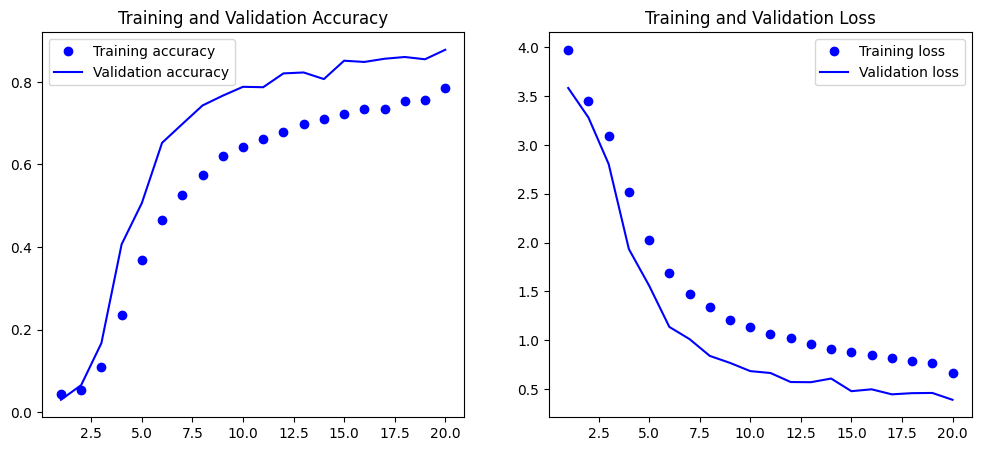

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [20]:
# Загрузка данных для предсказания
images_sub = np.load('data/images_sub.npy')

In [21]:
# Нормализация изображений
images_sub = images_sub / 255.0
# Выполнение предсказаний
predictions = model.predict(images_sub)
predicted_labels = label_binarizer.inverse_transform(predictions)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step


In [22]:
# Создание DataFrame для отправки
submission = pd.DataFrame({'Id': np.arange(len(predicted_labels)), 'Category': predicted_labels})

# Проверка формата ответа
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        50000 non-null  int64
 1   Category  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB


In [23]:
# Сохранение файла
submission.to_csv('data/predictions_modify_layers.csv', index=False)